In [1]:
from urllib.request import urlopen as uRequest
from bs4 import BeautifulSoup as soup
import re
import pandas as pd
import os
from glob import glob
from os.path import join
from urllib.request import urlretrieve as retrieve

def scrape(page_url, records = []):
    uClient = uRequest(page_url)
    html_page = uClient.read()
    page_soup = soup(html_page)

    records = []

    containers = page_soup.findAll('div', {'class':'extensible-article'})
    for container in containers:
        manufacturer  = container.findAll('span', {'class':'manufacturer'})[0].text #anche se la variabile ha un solo elemento dobbiamo comunque indicizzarlo
        model = container.findAll('span', {'class':'model'})[0].text
        image  = container.findAll('div',{'class':'product-image'})[0].img['src']
        price = container.findAll('span',{'class' : 'article-basketlink'})[0].text
        price = float(price.replace('€', '').replace(',','.'))
        reviews_no = int(container.findAll('span', {'class':'count'})[0].text)
        availability = container.findAll('span', {'class':'rs-layover-trigger-text'})[0].text
        rating = container.findAll('span', {'class':'overlay-wrapper'})[0]['style']
        rating = float(re.search('[0-9]+(\.[0-9]+)?',rating).group())
        records.append([manufacturer, model, image, price, reviews_no, availability, rating])
    return records

def navigate_scrape(f_page_url, records = []):
    results = []
    page_html = uRequest(f_page_url).read()
    page_soup = soup(page_html)
    page_links = [c.a['href'] for c in \
                  list(filter(lambda c: 'active' not in c['class'], page_soup.findAll('div', {'class':'page'})))]
    base_url = re.search('http(s)?://[^/]*',f_page_url).group(0)
    page_links = [base_url + l for l in page_links]
    page_links = [f_page_url] + page_links
    
    for url in page_links:
        print(url)
        records = (scrape(url, records))
        for r in records:
            results.append(r)
    return results

def download_images(data, dest_dir, img_name = "img_{id:05d}.{ext:s}"):    
    data = data.copy()
    data['img_path'] = None
    img_paths = []
    for i, row in data.iterrows():
        ext = re.search('[^.]+$',row['image']).group() #cerchiamo l'estensione dell'immagine es .png
        path = join(dest_dir, img_name.format(id=int(row.name), ext = ext))
        retrieve(row['image'],path)
        img_paths.append(path)
    data['img_path'] = img_paths
    return data

page_html = uRequest('https://www.thomann.de/it/ukuleles.html').read()
page_soup = soup(page_html)
grid_container = page_soup.findAll('div', {'class':'subcategories'})[0]
products_container = grid_container.findAll('li', {'class':'item'})

page_links = [p.a['href'] for p in products_container]
categories = [c.a.text.strip() for c in products_container]

records = []
cats = []
for category, link in zip(categories, page_links):
    len_before = len(records)
    records += navigate_scrape(link, records)
    num_records = len(records) - len_before
    cats += [category]*num_records
print(len(cats))
data = pd.DataFrame(records, columns=['manufacturer','model','image','price','review_no','availability','rating'])
data.info()
data.head()

https://www.thomann.de/it/ukulele_soprani.html
https://www.thomann.de/it/ukulele_soprani.html?pg=2&ls=25
https://www.thomann.de/it/ukulele_soprani.html?pg=3&ls=25
https://www.thomann.de/it/ukulele_soprani.html?pg=4&ls=25
https://www.thomann.de/it/ukulele_soprani.html?pg=5&ls=25
https://www.thomann.de/it/ukulele_soprani.html?pg=6&ls=25
https://www.thomann.de/it/ukulele_soprani.html?pg=7&ls=25
https://www.thomann.de/it/ukulele_da_concerto.html
https://www.thomann.de/it/ukulele_da_concerto.html?pg=2&ls=25
https://www.thomann.de/it/ukulele_da_concerto.html?pg=3&ls=25
https://www.thomann.de/it/ukulele_da_concerto.html?pg=4&ls=25
https://www.thomann.de/it/ukulele_da_concerto.html?pg=5&ls=25
https://www.thomann.de/it/ukulele_da_concerto.html?pg=6&ls=25
https://www.thomann.de/it/ukulele_da_concerto.html?pg=7&ls=25
https://www.thomann.de/it/ukulele_tenori.html
https://www.thomann.de/it/ukulele_tenori.html?pg=2&ls=25
https://www.thomann.de/it/ukulele_tenori.html?pg=3&ls=25
https://www.thomann.de

,manufacturer,model,image,price,review_no,availability,rating
0,Harley Benton,UK-12 Black,https://thumbs.static-thomann.de/thumb/thumb15...,19.9,357,Disponibilità immediata,78.543
1,Harley Benton,Ukulele UK-11DW Brown,https://thumbs.static-thomann.de/thumb/thumb15...,17.9,437,Disponibilità immediata,84.073
2,Harley Benton,Ukulele Pack,https://thumbs.static-thomann.de/thumb/thumb15...,30.0,20,Disponibilità immediata,88.000
3,Kala,Makala Shark SS-BLK,https://thumbs.static-thomann.de/thumb/thumb15...,55.0,0,Disponibilità immediata,0.000
4,Harley Benton,Hawaii Koa Soprano Ukulele,https://thumbs.static-thomann.de/thumb/thumb15...,99.0,13,Disponibilità immediata,93.846


In [2]:
data['category'] = cats

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
manufacturer    925 non-null object
model           925 non-null object
image           925 non-null object
price           925 non-null float64
review_no       925 non-null int64
availability    925 non-null object
rating          925 non-null float64
category        925 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 57.9+ KB


In [4]:
data.describe()

,price,review_no,rating
count,925.000000,925.000000,925.000000
mean,109.116002,26.535135,65.167356
std,137.302730,210.400217,40.592714
min,0.990000,0.000000,0.000000
25%,18.900000,0.000000,0.000000
50%,55.000000,2.000000,86.666000
75%,144.000000,10.000000,94.736000
max,999.000000,5638.000000,100.000000


In [5]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
data.groupby('category')['category'].count().plot.pie(rotatelabels=True)
plt.show()

<Figure size 800x800 with 1 Axes>

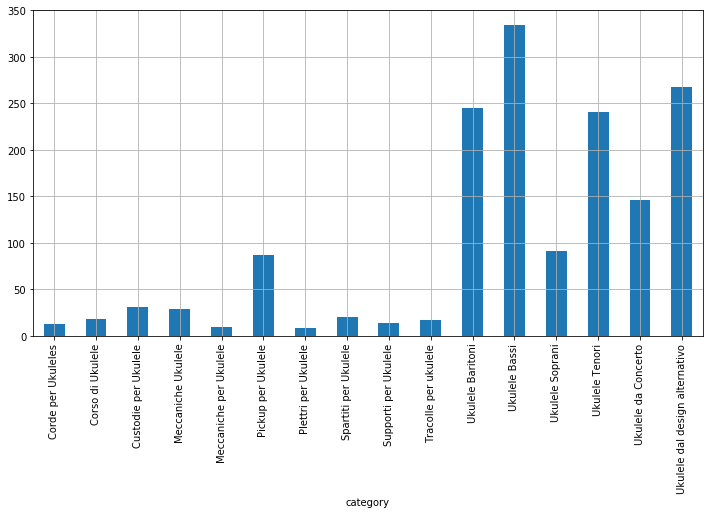

In [6]:
plt.figure(figsize=(12,6))
data.groupby('category')['price'].mean().plot.bar()
plt.grid()
plt.show()

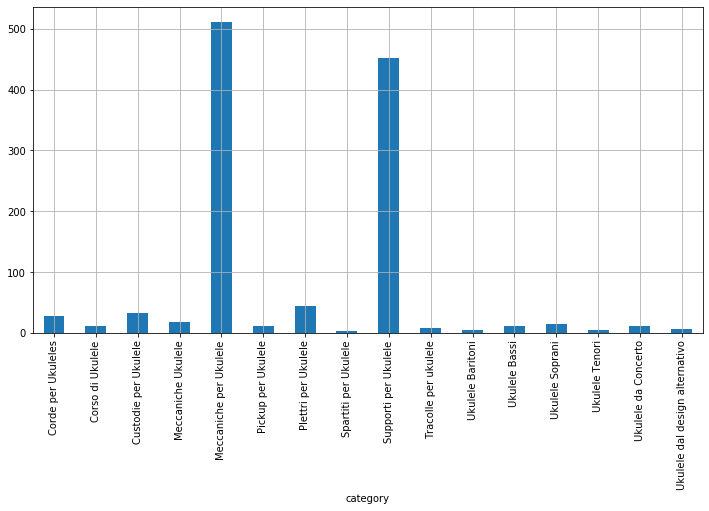

In [7]:
plt.figure(figsize=(12,6))
data.groupby('category')['review_no'].mean().plot.bar()
plt.grid()
plt.show()

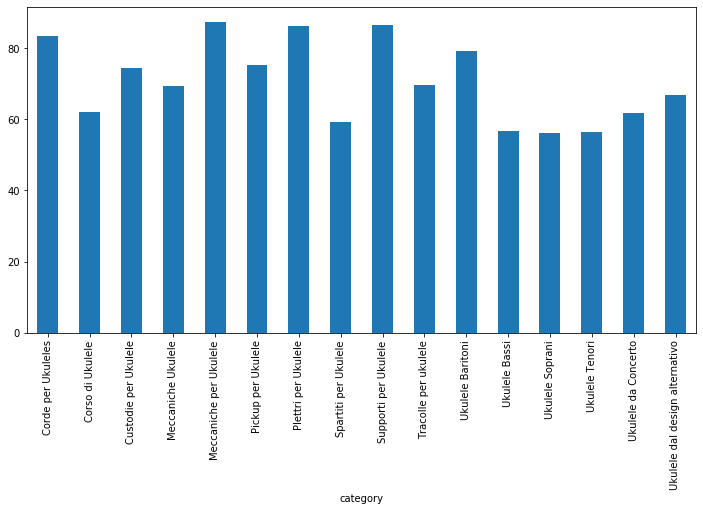

In [9]:
plt.figure(figsize=(12,6))
data.groupby('category')['rating'].mean().plot.bar()
plt.show()

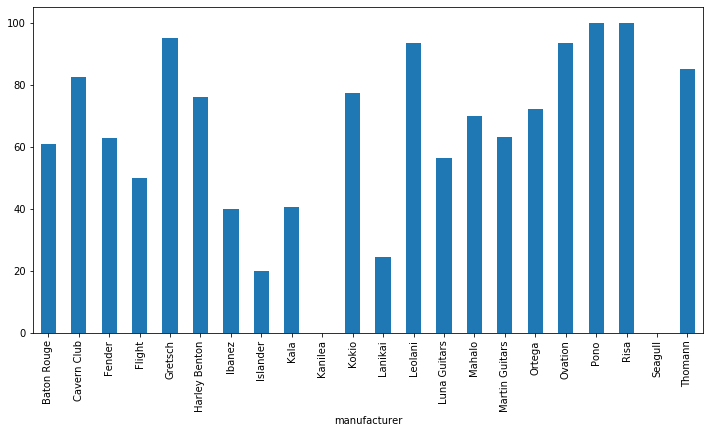

In [14]:
plt.figure(figsize=(12,6))
data[data['category']=='Ukulele Soprani'].groupby('manufacturer')['rating'].mean().plot.bar()
plt.show()